In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler,Normalizer,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_validate,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, chi2, SelectFromModel,mutual_info_classif
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
import warnings
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv('Datasets\\Loan Approval\\Loan_train.csv')
test=pd.read_csv('Datasets\\Loan Approval\\Loan_test.csv')
train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


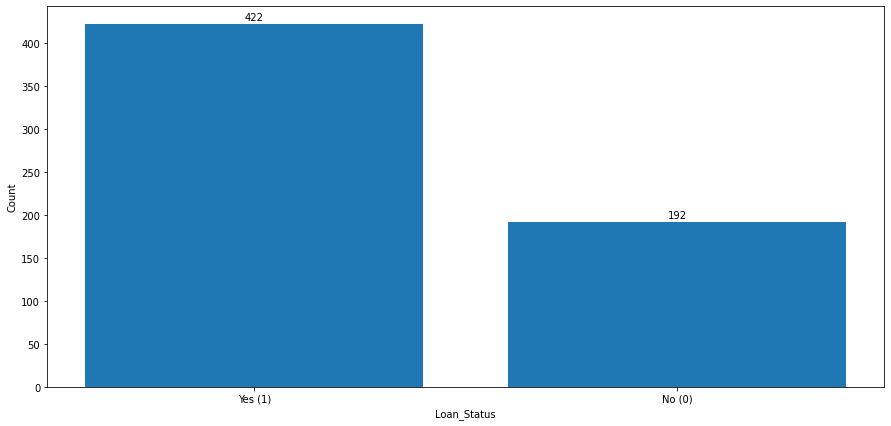

In [3]:
fig,ax=plt.subplots(figsize=(15,7))
ax.bar(train.Loan_Status.value_counts().index,train.Loan_Status.value_counts().values)
ax.set_xlabel('Loan_Status')
ax.set_ylabel('Count')
ax.set_xticks([0,1])
ax.set_xticklabels(['Yes (1)','No (0)'])
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

In [4]:
x=train[[x for x in train.columns if x !='Loan_Status']]
y=train[['Loan_Status']]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=1)
sub_train=x_train.join(y_train)
sub_test=x_test.join(y_test)

# Null Value Detection and Imputation

In [5]:
sub_train_null_counts=pd.DataFrame(sub_train.isnull().sum(),columns=['sub_train_null_count'])
sub_train_null_counts=sub_train_null_counts.loc[sub_train_null_counts.sub_train_null_count>0]
sub_test_null_counts=pd.DataFrame(sub_test.isnull().sum(),columns=['sub_test_null_count'])
sub_test_null_counts=sub_test_null_counts.loc[sub_test_null_counts.sub_test_null_count>0]
null_counts=sub_test_null_counts.join(sub_train_null_counts).fillna(0)
null_counts['sub_train_null_%']=round((null_counts['sub_train_null_count']/sub_train.shape[0])*100,2)
null_counts['sub_test_null_%']=round((null_counts['sub_test_null_count']/sub_test.shape[0])*100,2)
null_counts

,sub_test_null_count,sub_train_null_count,sub_train_null_%,sub_test_null_%
Gender,4,9,1.83,3.25
Married,1,2,0.41,0.81
Dependents,5,10,2.04,4.07
Self_Employed,8,24,4.89,6.50
LoanAmount,5,17,3.46,4.07
Loan_Amount_Term,4,10,2.04,3.25
Credit_History,6,44,8.96,4.88


In [6]:
sub_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 291 to 37
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             482 non-null    object 
 2   Married            489 non-null    object 
 3   Dependents         481 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      467 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         474 non-null    float64
 9   Loan_Amount_Term   481 non-null    float64
 10  Credit_History     447 non-null    float64
 11  Property_Area      491 non-null    object 
 12  Loan_Status        491 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 69.9+ KB


In [7]:
# Categorical
for i in [x for x in null_counts.index.to_list() if x not in ['Loan_Amount_Term','LoanAmount']]:
    sub_train[i].fillna(sub_train[i].mode().values[0],inplace=True)
    sub_test[i].fillna(sub_test[i].mode().values[0],inplace=True)

# Numerical    
for i in ['Loan_Amount_Term','LoanAmount']:
    sub_train[i].fillna(sub_train[i].median(),inplace=True)
    sub_test[i].fillna(sub_test[i].median(),inplace=True)

# Exploratory Data Analysis

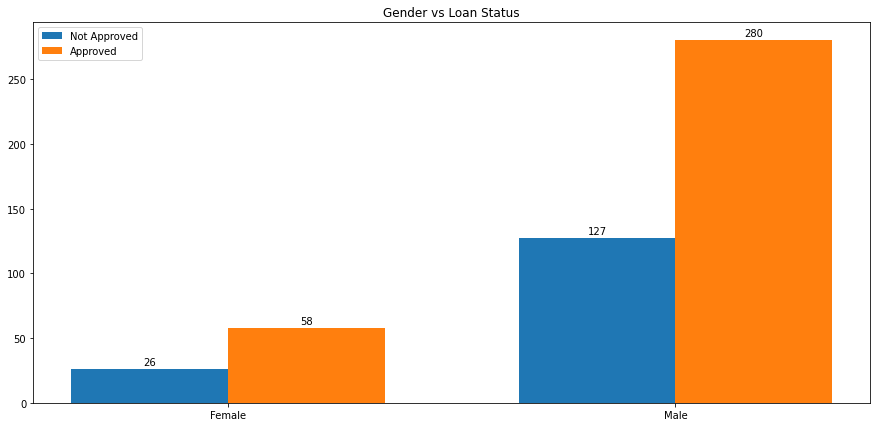

In [8]:
group=pd.DataFrame(sub_train.groupby(['Loan_Status','Gender']).count()['Loan_ID'])
width=.35
x=np.arange(len(group.loc['N'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].Loan_ID], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].Loan_ID], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['N'].index)
ax.legend()
ax.set_title('Gender vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

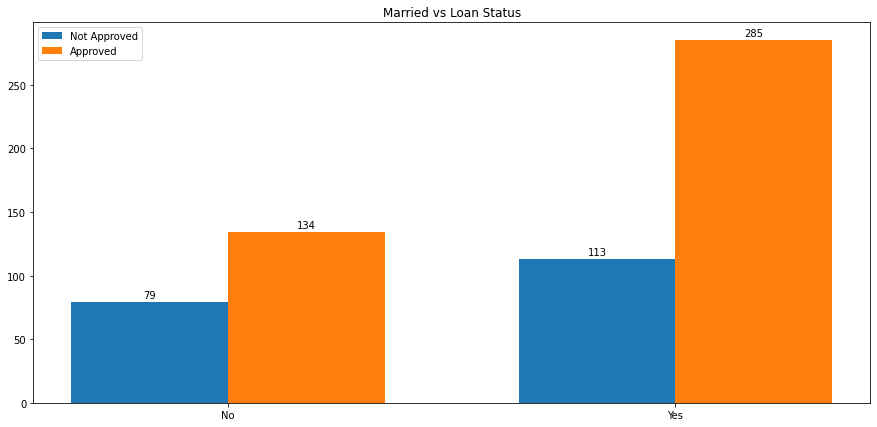

In [9]:
group=pd.DataFrame(train.groupby(['Loan_Status','Married']).count()['Loan_ID'])
width=.35
x=np.arange(len(group.loc['N'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].Loan_ID], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].Loan_ID], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['N'].index)
ax.legend()
ax.set_title('Married vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

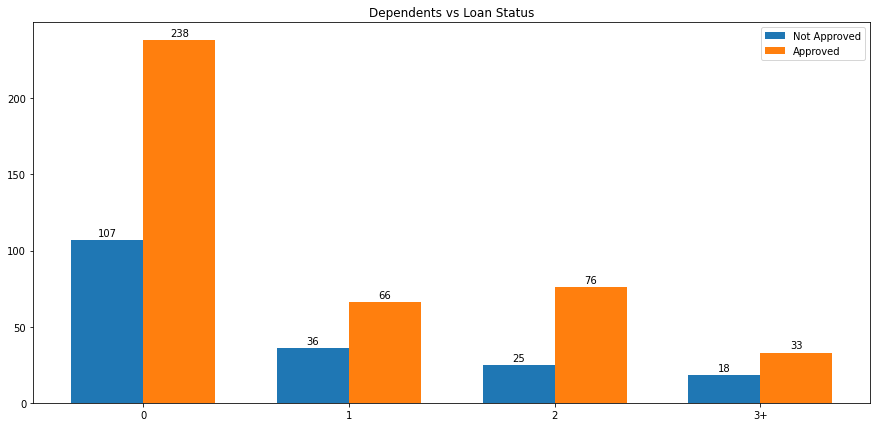

In [10]:
group=pd.DataFrame(train.groupby(['Loan_Status','Dependents']).count()['Loan_ID'])
width=.35
x=np.arange(len(group.loc['N'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].Loan_ID], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].Loan_ID], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['N'].index)
ax.legend()
ax.set_title('Dependents vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

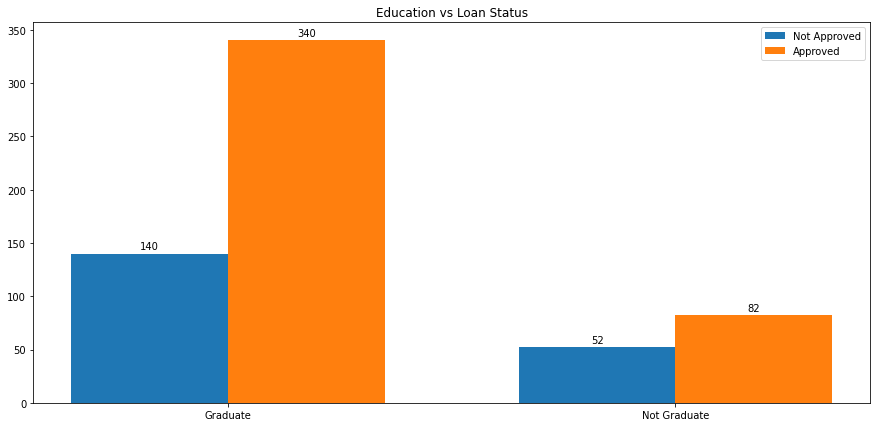

In [11]:
group=pd.DataFrame(train.groupby(['Loan_Status','Education']).count()['Loan_ID'])
width=.35
x=np.arange(len(group.loc['N'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].Loan_ID], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].Loan_ID], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['N'].index)
ax.legend()
ax.set_title('Education vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

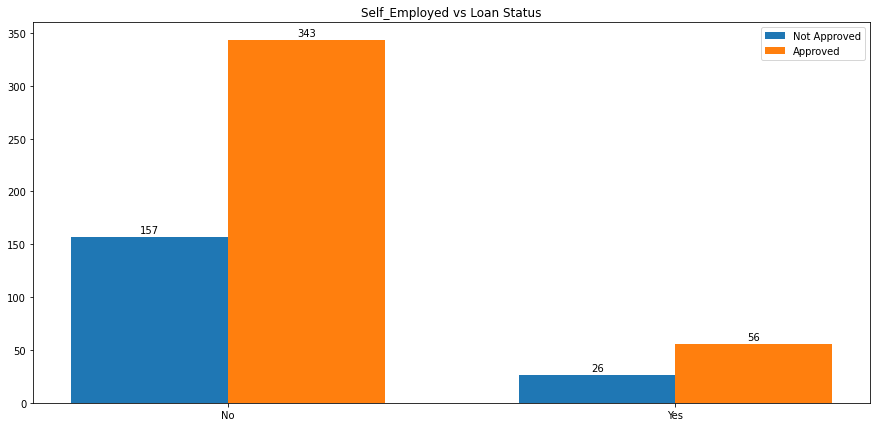

In [12]:
group=pd.DataFrame(train.groupby(['Loan_Status','Self_Employed']).count()['Loan_ID'])
width=.35
x=np.arange(len(group.loc['N'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].Loan_ID], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].Loan_ID], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['N'].index)
ax.legend()
ax.set_title('Self_Employed vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

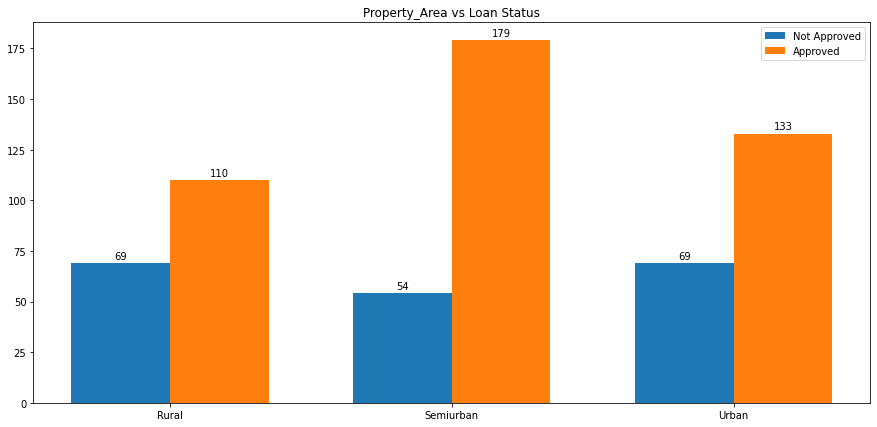

In [13]:
group=pd.DataFrame(train.groupby(['Loan_Status','Property_Area']).count()['Loan_ID'])
width=.35
x=np.arange(len(group.loc['N'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].Loan_ID], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].Loan_ID], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['N'].index)
ax.legend()
ax.set_title('Property_Area vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

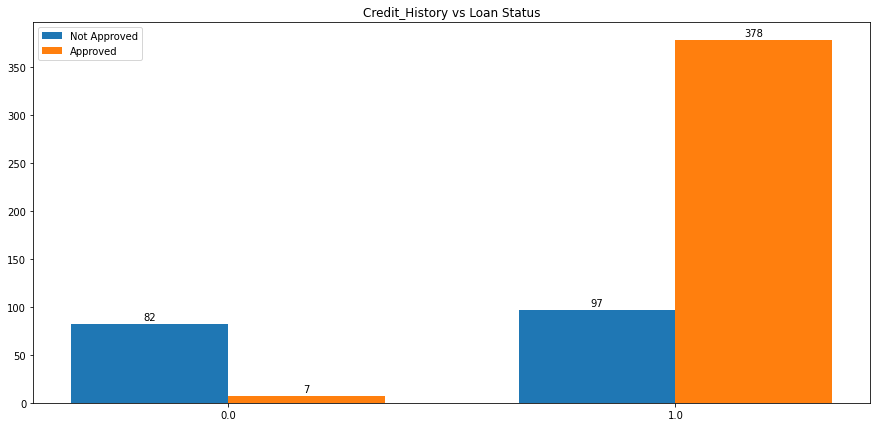

In [14]:
group=pd.DataFrame(train.groupby(['Loan_Status','Credit_History']).count()['Loan_ID'])
width=.35
x=np.arange(len(group.loc['N'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].Loan_ID], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].Loan_ID], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['N'].index)
ax.legend()
ax.set_title('Credit_History vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

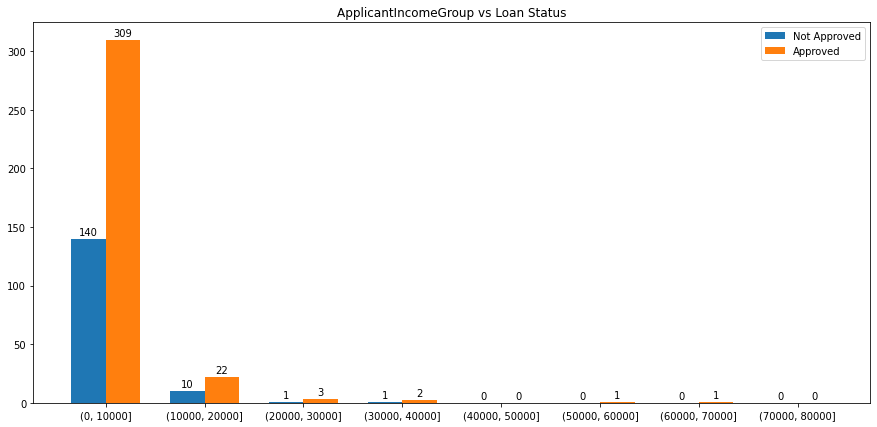

In [15]:
group=sub_train[['Loan_Status','ApplicantIncome']]
group['bins']=pd.cut(x=group['ApplicantIncome'],bins=[0,10000,20000,30000,40000,50000,60000,70000,80000])
group=pd.DataFrame(group.groupby(['Loan_Status','bins']).count()['ApplicantIncome'])
width=.35
x=np.arange(len(group.loc['N'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].ApplicantIncome], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].ApplicantIncome], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['N'].index)
ax.legend()
ax.set_title('ApplicantIncomeGroup vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

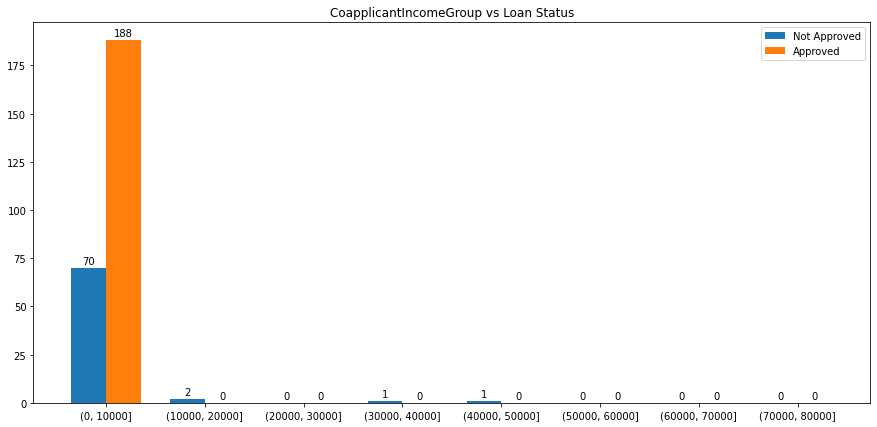

In [16]:
group=sub_train[['Loan_Status','CoapplicantIncome']]
group['bins']=pd.cut(x=group['CoapplicantIncome'],bins=[0,10000,20000,30000,40000,50000,60000,70000,80000])
group=pd.DataFrame(group.groupby(['Loan_Status','bins']).count()['CoapplicantIncome'])
width=.35
x=np.arange(len(group.loc['N'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].CoapplicantIncome], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].CoapplicantIncome], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['N'].index)
ax.legend()
ax.set_title('CoapplicantIncomeGroup vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

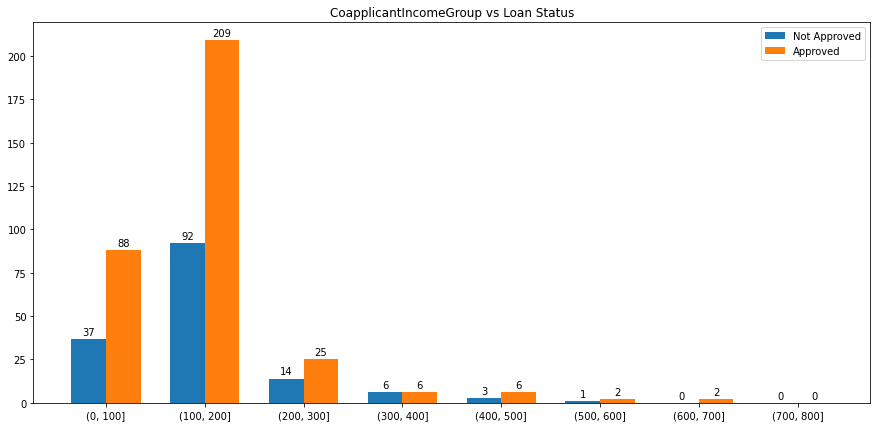

In [17]:
group=sub_train[['Loan_Status','LoanAmount']]
group['bins']=pd.cut(x=group['LoanAmount'],bins=[0,100,200,300,400,500,600,700,800])
group=pd.DataFrame(group.groupby(['Loan_Status','bins']).count()['LoanAmount'])
width=.35
x=np.arange(len(group.loc['N'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].LoanAmount], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].LoanAmount], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['N'].index)
ax.legend()
ax.set_title('CoapplicantIncomeGroup vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

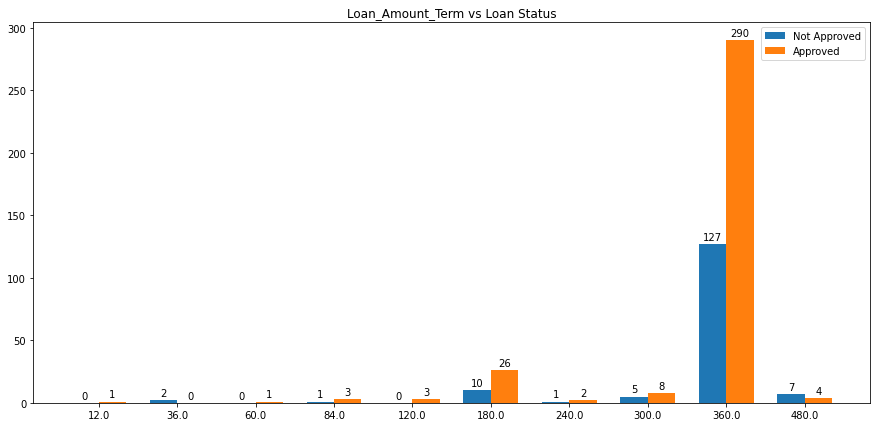

In [18]:
group=pd.DataFrame(sub_train.groupby(['Loan_Status','Loan_Amount_Term']).count()['Loan_ID'])
group=group.reindex(pd.MultiIndex.from_product([group.index.get_level_values(0).unique().sort_values(),
                                                group.index.get_level_values(1).unique().sort_values()],
                                               names=['Loan_Status','Loan_Amount_Term'])).fillna(0)
width=.35
x=np.arange(len(group.loc['Y'].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in group.loc['N'].Loan_ID], width, label='Not Approved')
rects2 = ax.bar(x + width/2, [i for i in group.loc['Y'].Loan_ID], width, label='Approved')
ax.set_xticks(x)
ax.set_xticklabels(group.loc['Y'].index)
ax.legend()
ax.set_title('Loan_Amount_Term vs Loan Status')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

# Model Evaluation and Selection

In [19]:
sub_train['Loan_Status']=sub_train['Loan_Status'].apply(lambda x:1 if x=='Y' else 0)
sub_test['Loan_Status']=sub_test['Loan_Status'].apply(lambda x:1 if x=='Y' else 0)

In [20]:
drop=['Loan_ID','Loan_Status']

x=sub_train[[x for x in sub_train.columns if x not in drop]]
y=sub_train[['Loan_Status']]

xx=sub_test[[x for x in sub_test.columns if x not in drop]]
yy=sub_test[['Loan_Status']]

In [21]:
ct=ColumnTransformer([('ohe',OneHotEncoder(sparse=False, handle_unknown='ignore'),
                       ['Gender', 'Married', 'Education','Self_Employed','Credit_History']),
                     ('oe',OrdinalEncoder(),['Property_Area','Dependents'])],remainder='passthrough')

In [22]:
models=[LogisticRegression(random_state=1),LinearDiscriminantAnalysis(),LinearSVC(random_state=1),
        RandomForestClassifier(random_state=1),BaggingClassifier(random_state=1)]
scales=[RobustScaler(),StandardScaler(),Normalizer()]
result=[]
for model in models:
    final=[]
    for scale in scales:
        pipe=Pipeline([('ct',ct),('scale',scale),('model',model)])
        score=cross_val_score(estimator=pipe,X=x,y=np.array(y).ravel(),cv=5,n_jobs=-1,scoring='f1').mean()
        final.append(round(score*100,2))
    result.append(final)
pd.DataFrame(result,index=['Logistic Regression','LinearDiscriminantAnalysis','LinearSVC',
                          'RandomForestClassifier','BaggingClassifier'],columns=['Robust Scaler','Standard Scaler','Normalizer'])

,Robust Scaler,Standard Scaler,Normalizer
Logistic Regression,87.97,87.97,81.54
LinearDiscriminantAnalysis,87.97,87.97,87.78
LinearSVC,86.74,87.97,81.64
RandomForestClassifier,86.90,87.05,85.91
BaggingClassifier,81.55,81.38,82.65


In [23]:
pipe=Pipeline([('ct',ct),('scale',StandardScaler()),('model',LogisticRegression())])
pipe.fit(x,y)
y_pred=pipe.predict(xx)
metrics_df=pd.DataFrame(data=[metrics.f1_score(yy,y_pred),metrics.precision_score(yy,y_pred),
                              metrics.recall_score(yy,y_pred),metrics.accuracy_score(yy,y_pred)],
                        index=['F1 Score','Precision','Recall','Accuracy'],
                        columns=['Score'])
metrics_df

,Score
F1 Score,0.867725
Precision,0.780952
Recall,0.976190
Accuracy,0.796748


Text(0.5, 1.0, 'Confusion Matrix')

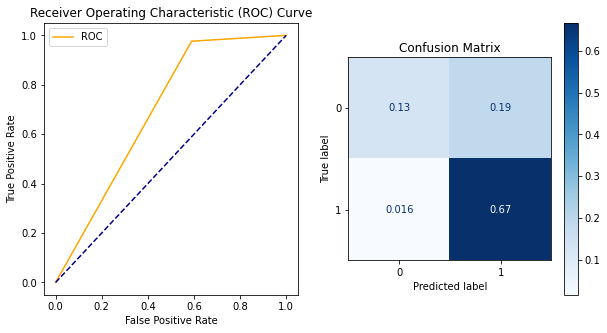

In [24]:
fper, tper, thresholds = metrics.roc_curve(yy, y_pred)
fig,ax=plt.subplots(figsize=(10,5),nrows=1,ncols=2)
ax[0].plot(fper, tper, color='orange', label='ROC')
ax[0].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend()
metrics.plot_confusion_matrix(pipe, xx, yy,cmap=plt.cm.Blues, normalize = 'all',ax=ax[1])
ax[1].set_title('Confusion Matrix')

# Predicting Loan Approval Status on Test Data

In [25]:
train_null_counts=pd.DataFrame(train.isnull().sum(),columns=['train_null_count'])
train_null_counts=train_null_counts.loc[train_null_counts.train_null_count>0]
test_null_counts=pd.DataFrame(test.isnull().sum(),columns=['test_null_count'])
test_null_counts=test_null_counts.loc[test_null_counts.test_null_count>0]
null_counts=test_null_counts.join(train_null_counts).fillna(0)
null_counts['train_null_%']=round((null_counts['train_null_count']/train.shape[0])*100,2)
null_counts['test_null_%']=round((null_counts['test_null_count']/test.shape[0])*100,2)
null_counts

,test_null_count,train_null_count,train_null_%,test_null_%
Gender,11,13,2.12,3.00
Dependents,10,15,2.44,2.72
Self_Employed,23,32,5.21,6.27
LoanAmount,5,22,3.58,1.36
Loan_Amount_Term,6,14,2.28,1.63
Credit_History,29,50,8.14,7.90


In [26]:
# Categorical
for i in [x for x in null_counts.index.to_list() if x not in ['Loan_Amount_Term','LoanAmount']]:
    train[i].fillna(train[i].mode().values[0],inplace=True)
    test[i].fillna(test[i].mode().values[0],inplace=True)

# Numerical    
for i in ['Loan_Amount_Term','LoanAmount']:
    train[i].fillna(train[i].mode().values[0],inplace=True)
    test[i].fillna(test[i].median(),inplace=True)

In [27]:
train['Loan_Status']=train['Loan_Status'].apply(lambda x:1 if x=='Y' else 0)

In [28]:
drop=['Loan_ID','Loan_Status']

x_train=train[[x for x in train.columns if x not in drop]]
y_train=train[['Loan_Status']]

x_test=test[[x for x in test.columns if x not in drop]]

In [29]:
ct=ColumnTransformer([('ohe',OneHotEncoder(sparse=False, handle_unknown='ignore'),
                       ['Gender', 'Married', 'Education','Self_Employed','Credit_History']),
                     ('oe',OrdinalEncoder(),['Property_Area','Dependents'])],remainder='passthrough')

In [30]:
pipe=Pipeline([('ct',ct),('scale',StandardScaler()),('model',LogisticRegression())])
pipe.fit(x_train,y_train)
y_pred=pipe.predict(x_test)

In [31]:
submission=test.join(pd.DataFrame(data=y_pred,columns=['Loan_Status']))[['Loan_ID','Loan_Status']]
submission

,Loan_ID,Loan_Status
0,LP001015,1
1,LP001022,1
2,LP001031,1
3,LP001035,1
4,LP001051,1
...,...,...
362,LP002971,1
363,LP002975,1
364,LP002980,1
365,LP002986,1
